In [ ]:
!pip install transformers[torch] datasets evaluate bleu sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
  Created wheel for bleu: filename=bleu-0.3-py3-none-any.whl size=5782 sha256=b206887d449416fdf436d24208e7295f2aa927fc23ab274b003823fbbd96a33f
  Stored in directory: /root/.cache/pip/wheels/c6/d8/d1/009abe01b8b2c6a14c62d197b510b3cc1076014c22d712c5ce
Successfully built bleu


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


# Data Loading

In [ ]:
from datasets import load_dataset
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = load_dataset("cfilt/iitb-english-hindi")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1659083 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/520 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2507 [00:00<?, ? examples/s]

In [ ]:
data["train"] = data["train"].select(range(127085))
data = data['train'].train_test_split(test_size = 0.2)
data

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 101668
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 25417
    })
})

# Data Preprocessing

In [ ]:
from transformers import T5Tokenizer
model_type = 'google/madlad400-3b-mt'
source_lang = "en"
target_lang = "hi"
tokenizer = T5Tokenizer.from_pretrained(model_type)

tokenizer_config.json:   0%|          | 0.00/830 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.43M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.6M [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    inputs = ['<2hi> '+example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [ ]:
tokenized_data = data.map(preprocess_function, batched=True)
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_type)

Map:   0%|          | 0/101668 [00:00<?, ? examples/s]

Map:   0%|          | 0/25417 [00:00<?, ? examples/s]

# Model Evaluation

In [ ]:
import evaluate
metric = evaluate.load('bleu')

In [ ]:
import numpy as np

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["bleu"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

# Training

In [ ]:
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = T5ForConditionalGeneration.from_pretrained(model_type)
model = model.to(device)

config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.8G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="madlad400-3b_hindi",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,0.000000,nan,0.315600,10.391500


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
trainer.push_to_hub()

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Anmol1902/madlad400-3b_hindi/commit/a89fb954fc2401e59b8d41aad329a8b3e5fafe71', commit_message='End of training', commit_description='', oid='a89fb954fc2401e59b8d41aad329a8b3e5fafe71', pr_url=None, pr_revision=None, pr_num=None)

# Model Inference

In [ ]:
text = '<2hi> my name is anmol'
text

'<2hi> my name is anmol'

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("madlad400-3b_hindi")
inputs = tokenizer(text, return_tensors="pt").input_ids

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("madlad400-3b_hindi")
outputs = model.generate(input_ids=inputs)
tokenizer.decode(outputs[0], skip_special_tokens=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'मेरा नाम अनमोल है'

# Learning Curve

In [ ]:
# Extract the loss values
train_logs = trainer.state.log_history
train_losses = []
train_step = []

eval_losses = []
eval_step = []
for log in train_logs:
    if "loss" in log.keys():
        train_losses.append(log["loss"])
        train_step.append(log["step"])
    if "eval_loss" in log.keys():
        eval_losses.append(log["eval_loss"])
        eval_step.append(log["step"])
print(train_losses)
print(train_step)
print(eval_losses)
print(eval_step)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500]
[nan]
[12709]


In [ ]:
train_logs

[{'loss': 0.0,
  'grad_norm': nan,
  'learning_rate': 2e-05,
  'epoch': 0.04,
  'step': 500},
 {'loss': 0.0,
  'grad_norm': nan,
  'learning_rate': 2e-05,
  'epoch': 0.08,
  'step': 1000},
 {'loss': 0.0,
  'grad_norm': nan,
  'learning_rate': 2e-05,
  'epoch': 0.12,
  'step': 1500},
 {'loss': 0.0,
  'grad_norm': nan,
  'learning_rate': 2e-05,
  'epoch': 0.16,
  'step': 2000},
 {'loss': 0.0,
  'grad_norm': nan,
  'learning_rate': 2e-05,
  'epoch': 0.2,
  'step': 2500},
 {'loss': 0.0,
  'grad_norm': nan,
  'learning_rate': 2e-05,
  'epoch': 0.24,
  'step': 3000},
 {'loss': 0.0,
  'grad_norm': nan,
  'learning_rate': 2e-05,
  'epoch': 0.28,
  'step': 3500},
 {'loss': 0.0,
  'grad_norm': nan,
  'learning_rate': 2e-05,
  'epoch': 0.31,
  'step': 4000},
 {'loss': 0.0,
  'grad_norm': nan,
  'learning_rate': 2e-05,
  'epoch': 0.35,
  'step': 4500},
 {'loss': 0.0,
  'grad_norm': nan,
  'learning_rate': 2e-05,
  'epoch': 0.39,
  'step': 5000},
 {'loss': 0.0,
  'grad_norm': nan,
  'learning_rate'

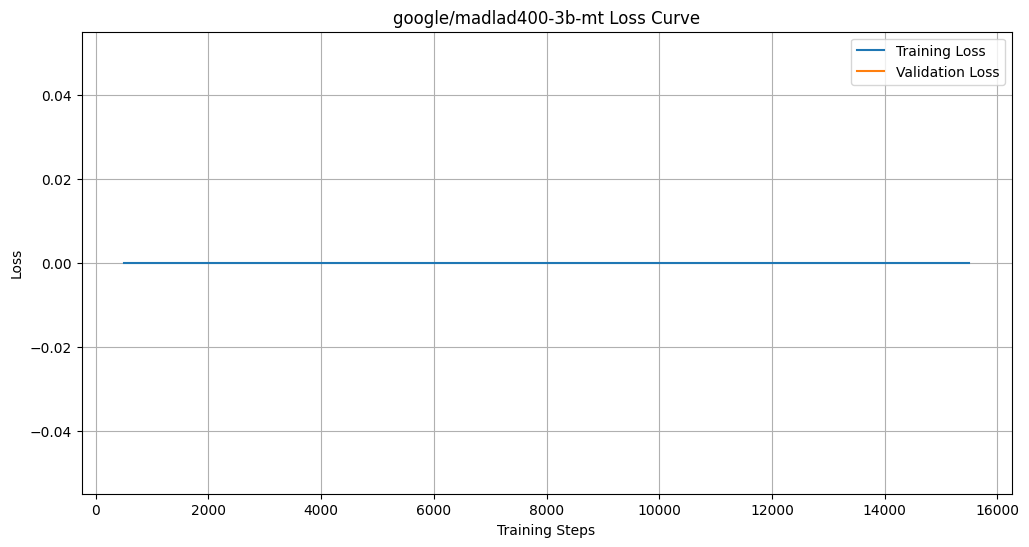

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for training losses
train_df = pd.DataFrame({'step': train_step, 'loss': train_losses})

# Create a DataFrame for evaluation losses
eval_df = pd.DataFrame({'step': eval_step, 'loss': eval_losses})

# Plot the training and evaluation losses
plt.figure(figsize=(12, 6))
sns.lineplot(x='step', y='loss', data=train_df, label='Training Loss')
sns.lineplot(x='step', y='loss', data=eval_df, label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title(model_type+' Loss Curve')
plt.legend()
plt.grid(True)
plt.show()
